In [2]:
# Imports

import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path ="/content/drive/MyDrive/2025-2/Machine Learning/proyecto1/"
train_df = pd.read_csv(path + "datos_entrenamiento_riesgo.csv")
test_df = pd.read_csv(path +  "datos_prueba_riesgo.csv")

In [4]:
# EDA
def impute_variables(train_df, test_df):
    categorical_encoded = ['sector_laboral', 'tipo_vivienda', 'nivel_educativo', 'estado_civil']
    for col in categorical_encoded:
        mode_train = train_df[col].mode()[0]
        train_df[col].fillna(mode_train, inplace=True)
        test_df[col].fillna(mode_train, inplace=True)

    numerical = ['porcentaje_utilizacion_credito', 'proporcion_pagos_a_tiempo',
                'residencia_antiguedad_meses', 'lineas_credito_abiertas']
    for col in numerical:
        median_train = train_df[col].median()
        train_df[col].fillna(median_train, inplace=True)
        test_df[col].fillna(median_train, inplace=True)
    return train_df, test_df

def normalize(x_train, x_test):
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

def add_bias(x):
    return np.column_stack([np.ones(x.shape[0]), x])

def encode_labels(y):
    label_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}
    return y.map(label_map).values

# Preparar datasets con imputación
train_imputed, test_imputed = impute_variables(train_df.copy(), test_df.copy())

# Separar features y targets
X_train_imputed = train_imputed.drop('nivel_riesgo', axis=1)
X_test_imputed = test_imputed.drop('nivel_riesgo', axis=1)
y_train_imputed = train_imputed['nivel_riesgo']
y_test_imputed = test_imputed['nivel_riesgo']

# Normalize
X_train_norm, X_test_norm = normalize(X_train_imputed, X_test_imputed)

# Agregar Bias
X_train = add_bias(X_train_norm)
X_test = add_bias(X_test_norm)

# Convertir etiquetas
y_train = encode_labels(y_train_imputed)
y_test = encode_labels(y_test_imputed)

/tmp/ipython-input-2240508736.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(mode_train, inplace=True)
/tmp/ipython-input-2240508736.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [5]:
# Modelo
import numpy as np

def initialize_weights(n_features, n_classes):
    np.random.seed(42)
    return np.random.randn(n_features, n_classes) * 0.01
def h(x, w):
    return np.dot(x, w)

def s(x, w):
    exp_scores = np.exp(h(x, w))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def Loss_function(x, y, w):
    probabilities = s(x, w)
    n_samples = x.shape[0]
    correct_class_probs = probabilities[np.arange(n_samples), y]
    epsilon = 1e-15
    return -np.mean(np.log(correct_class_probs + epsilon))

def Derivatives(x, y, w):
    n_samples = x.shape[0]
    probabilities = s(x, w)

    probabilities[np.arange(n_samples), y] -= 1

    gradients = (1/n_samples) * np.dot(x.T, probabilities)
    return gradients

def change_parameters(w, derivatives, alpha):
  return w - alpha * derivatives

def train(x_train, y_train, epochs, alpha, x_test, y_test):
    print(f"Número de muestras de entrenamiento: {len(x_train)}")

    n_features = x_train.shape[1]
    n_classes = len(np.unique(y_train))
    w_train = initialize_weights(n_features, n_classes)

    LossTrain = []
    LossTest = []

    for i in range(epochs):
        L_Train = Loss_function(x_train, y_train, w_train)
        L_Test = Loss_function(x_test, y_test, w_train)

        dW = Derivatives(x_train, y_train, w_train)
        w_train = change_parameters(w_train, dW, alpha)

        if i %100 == 0:
            print(f"Época {i}: L_Train = {L_Train:.4f}")

        LossTrain.append(L_Train)
        LossTest.append(L_Test)

    return w_train, LossTrain, LossTest

def test(x_test, y_test, w_train):

    y_pred_probs = s(x_test, w_train)
    y_pred = np.argmax(y_pred_probs, axis=1)

    correctos = np.sum(y_pred == y_test)
    total = len(y_test)
    porc_aciertos = (correctos / total) * 100

    print(f"Número de datos correctos: {correctos}")
    print(f"Porcentaje de aciertos: {porc_aciertos:.2f}%")
    print(f"Porcentaje de error: {100 - porc_aciertos:.2f}%")

    return y_pred, porc_aciertos

In [6]:
# Matriz de confusión
def analyze_results(y_true, y_pred, title="Matriz de Confusión"):
  cm = confusion_matrix(y_true, y_pred)
  class_names = ['Bajo', 'Medio', 'Alto']

  cm_decimal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm_decimal, annot=True, fmt='.3f', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names, cbar=False)

  plt.title(title)
  plt.tight_layout()
  filename = f'{title.replace(" ", "_").replace("-", "_")}_decimal.png'
  plt.show()

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1028
Época 100: L_Train = 0.2655
Época 200: L_Train = 0.2035
Época 300: L_Train = 0.1748
Época 400: L_Train = 0.1573
Época 500: L_Train = 0.1450
Época 600: L_Train = 0.1358
Época 700: L_Train = 0.1285
Época 800: L_Train = 0.1225
Época 900: L_Train = 0.1175
Época 1000: L_Train = 0.1132
Época 1100: L_Train = 0.1095
Época 1200: L_Train = 0.1062
Época 1300: L_Train = 0.1033
Época 1400: L_Train = 0.1006
Época 1500: L_Train = 0.0982
Época 1600: L_Train = 0.0961
Época 1700: L_Train = 0.0940
Época 1800: L_Train = 0.0922
Época 1900: L_Train = 0.0905
Época 2000: L_Train = 0.0889
Época 2100: L_Train = 0.0874
Época 2200: L_Train = 0.0860
Época 2300: L_Train = 0.0847
Época 2400: L_Train = 0.0834
Época 2500: L_Train = 0.0823
Época 2600: L_Train = 0.0812
Época 2700: L_Train = 0.0801
Época 2800: L_Train = 0.0791
Época 2900: L_Train = 0.0782
Época 3000: L_Train = 0.0772
Época 3100: L_Train = 0.0764
Época 3200: L_Train = 0.0755
Época 3300: 

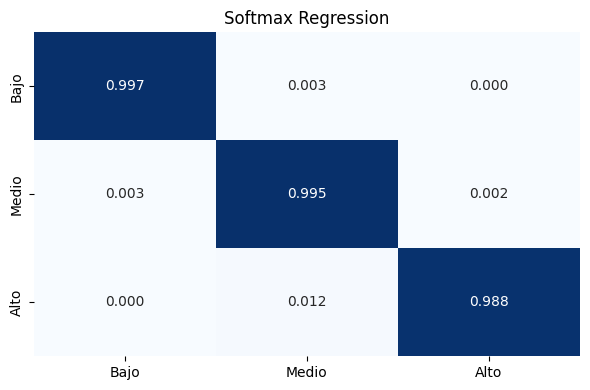

In [8]:
# Correr el modelo sin Feature Selection o Feature Extraction

# Definir Hiperparametros
alpha = 0.5
epochs = 5000

W, LossTrain, LossTest = train(
      X_train, y_train, epochs, alpha, X_test, y_test
  )

y_pred, accuracy = test(X_test, y_test, W)

analyze_results(y_test, y_pred, "Softmax Regression")


Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1057
Época 100: L_Train = 0.2116
Época 200: L_Train = 0.1634
Época 300: L_Train = 0.1411
Época 400: L_Train = 0.1273
Época 500: L_Train = 0.1177
Época 600: L_Train = 0.1104
Época 700: L_Train = 0.1046
Época 800: L_Train = 0.0998
Época 900: L_Train = 0.0958
Época 1000: L_Train = 0.0924
Época 1100: L_Train = 0.0894
Época 1200: L_Train = 0.0867
Época 1300: L_Train = 0.0844
Época 1400: L_Train = 0.0823
Época 1500: L_Train = 0.0803
Época 1600: L_Train = 0.0786
Época 1700: L_Train = 0.0769
Época 1800: L_Train = 0.0754
Época 1900: L_Train = 0.0740
Época 2000: L_Train = 0.0728
Época 2100: L_Train = 0.0715
Época 2200: L_Train = 0.0704
Época 2300: L_Train = 0.0693
Época 2400: L_Train = 0.0683
Época 2500: L_Train = 0.0674
Época 2600: L_Train = 0.0665
Época 2700: L_Train = 0.0656
Época 2800: L_Train = 0.0648
Época 2900: L_Train = 0.0640
Época 3000: L_Train = 0.0633
Época 3100: L_Train = 0.0626
Época 3200: L_Train = 0.0619
Época 3300: 

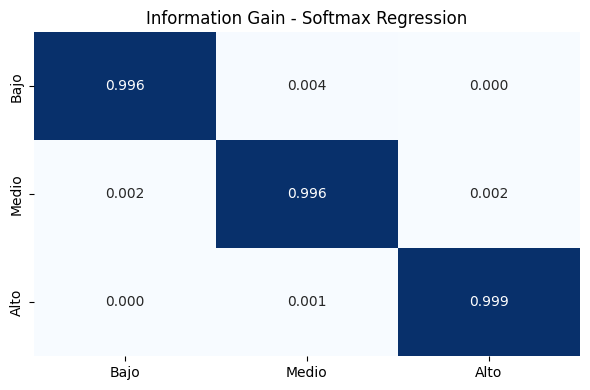

Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.1009
Época 100: L_Train = 0.7109
Época 200: L_Train = 0.7109
Época 300: L_Train = 0.7109
Época 400: L_Train = 0.7109
Época 500: L_Train = 0.7109
Época 600: L_Train = 0.7109
Época 700: L_Train = 0.7109
Época 800: L_Train = 0.7109
Época 900: L_Train = 0.7109
Época 1000: L_Train = 0.7109
Época 1100: L_Train = 0.7109
Época 1200: L_Train = 0.7109
Época 1300: L_Train = 0.7109
Época 1400: L_Train = 0.7109
Época 1500: L_Train = 0.7109
Época 1600: L_Train = 0.7109
Época 1700: L_Train = 0.7109
Época 1800: L_Train = 0.7109
Época 1900: L_Train = 0.7109
Época 2000: L_Train = 0.7109
Época 2100: L_Train = 0.7109
Época 2200: L_Train = 0.7109
Época 2300: L_Train = 0.7109
Época 2400: L_Train = 0.7109
Época 2500: L_Train = 0.7109
Época 2600: L_Train = 0.7109
Época 2700: L_Train = 0.7109
Época 2800: L_Train = 0.7109
Época 2900: L_Train = 0.7109
Época 3000: L_Train = 0.7109
Época 3100: L_Train = 0.7109
Época 3200: L_Train = 0.7109
Época 3300: 

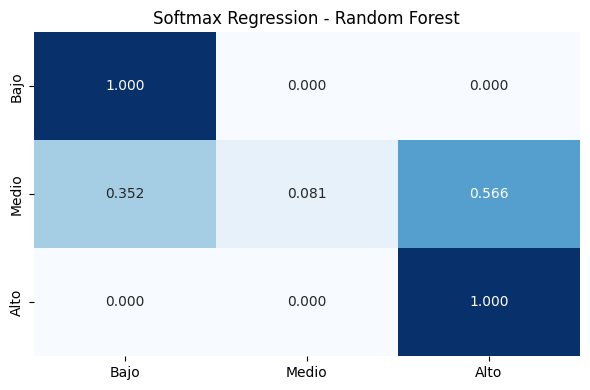

Varianza explicada acumulada con 30 componentes: 0.8894
Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.0960
Época 100: L_Train = 0.7333
Época 200: L_Train = 0.7333
Época 300: L_Train = 0.7333
Época 400: L_Train = 0.7333
Época 500: L_Train = 0.7333
Época 600: L_Train = 0.7333
Época 700: L_Train = 0.7333
Época 800: L_Train = 0.7333
Época 900: L_Train = 0.7333
Época 1000: L_Train = 0.7333
Época 1100: L_Train = 0.7333
Época 1200: L_Train = 0.7333
Época 1300: L_Train = 0.7333
Época 1400: L_Train = 0.7333
Época 1500: L_Train = 0.7333
Época 1600: L_Train = 0.7333
Época 1700: L_Train = 0.7333
Época 1800: L_Train = 0.7333
Época 1900: L_Train = 0.7333
Época 2000: L_Train = 0.7333
Época 2100: L_Train = 0.7333
Época 2200: L_Train = 0.7333
Época 2300: L_Train = 0.7333
Época 2400: L_Train = 0.7333
Época 2500: L_Train = 0.7333
Época 2600: L_Train = 0.7333
Época 2700: L_Train = 0.7333
Época 2800: L_Train = 0.7333
Época 2900: L_Train = 0.7333
Época 3000: L_Train = 0.7333
Época 3100: L_

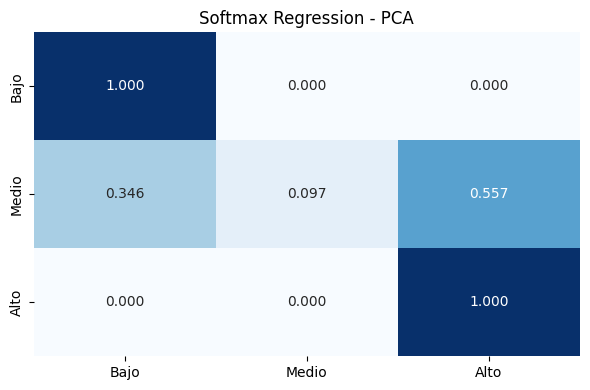

In [7]:
# Implementar reducción de dimensionalidad

def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_ig, X_test_ig, ig_indices = information_gain_selection(
  X_train, y_train, X_test, k=25
)

w_ig, loss_train_ig, loss_test_ig = train(
        X_train_ig,
        y_train,
        epochs,
        alpha,
        X_test_ig,
        y_test,
    )
y_pred_ig, acc_ig = test(X_test_ig, y_test, w_ig)
analyze_results(
    y_test, y_pred_ig, "Information Gain - Softmax Regression"
)

def random_forest_feature_importance(X_train, y_train, X_test, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    top_k_indices = np.argsort(importances)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

X_train_rf, X_test_rf, rf_indices = random_forest_feature_importance(
        X_train, y_train, X_test, k=25
    )

w_rf, loss_train_rf, loss_test_rf = train(
    X_train_rf,
    y_train,
    epochs,
    alpha,
    X_test_rf,
    y_test,
)
y_pred_rf, acc_rf = test(X_test_rf, y_test, w_rf)
analyze_results(y_test, y_pred_rf, "Softmax Regression - Random Forest")

def pca_dimensionality_reduction(X_train, X_test, n_components):

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return X_train_pca, X_test_pca, cumulative_variance

X_train_pca, X_test_pca, variance_explained = pca_dimensionality_reduction(
        X_train, X_test, n_components=30
    )
print(
    f"Varianza explicada acumulada con 30 componentes: {variance_explained[-1]:.4f}"
)

w_pca, loss_train_pca, loss_test_pca = train(
    X_train_pca,
    y_train,
    epochs,
    alpha,
    X_test_pca,
    y_test,
)
y_pred_pca, acc_pca = test(
    X_test_pca, y_test, w_pca
)
analyze_results(y_test, y_pred_pca, "Softmax Regression - PCA")

In [1]:
def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

f1_base = calculate_f1_score(y_test, y_pred)

f1_ig = calculate_f1_score(y_test, y_pred_ig)

f1_rf = calculate_f1_score(y_test, y_pred_rf)

f1_pca = calculate_f1_score(y_test, y_pred_pca)

models = ['Softmax\nRegression', 'Information Gain\n+ Softmax', 'Random Forest\n+ Softmax', 'PCA\n+ Softmax']
f1_scores = [f1_base, f1_ig, f1_rf, f1_pca]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)

plt.title('Comparación F1-Score entre Modelos', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.ylim(0, 1.0)

for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2,
             f'{score:.3f}', ha='center', va='center', fontweight='bold',
             color='white', fontsize=12)

plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='F1 = 0.5 (referencia)')

plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



print("F1-Scores calculados:")
print(f"Softmax Regression: {f1_base:.3f}")
print(f"Information Gain + Softmax: {f1_ig:.3f}")
print(f"Random Forest + Softmax: {f1_rf:.3f}")
print(f"PCA + Softmax: {f1_pca:.3f}")

NameError: name 'y_test' is not defined

Número de muestras de entrenamiento: 20000
Época 0: L_Train = 1.0972
Época 100: L_Train = 0.2656
Época 200: L_Train = 0.2036
Época 300: L_Train = 0.1749
Época 400: L_Train = 0.1574
Época 500: L_Train = 0.1451
Época 600: L_Train = 0.1359
Época 700: L_Train = 0.1286
Época 800: L_Train = 0.1226
Época 900: L_Train = 0.1176
Época 1000: L_Train = 0.1134
Época 1100: L_Train = 0.1096
Época 1200: L_Train = 0.1063
Época 1300: L_Train = 0.1034
Época 1400: L_Train = 0.1007
Época 1500: L_Train = 0.0984
Época 1600: L_Train = 0.0962
Época 1700: L_Train = 0.0942
Época 1800: L_Train = 0.0923
Época 1900: L_Train = 0.0906
Época 2000: L_Train = 0.0890
Época 2100: L_Train = 0.0875
Época 2200: L_Train = 0.0861
Época 2300: L_Train = 0.0848
Época 2400: L_Train = 0.0836
Época 2500: L_Train = 0.0824
Época 2600: L_Train = 0.0813
Época 2700: L_Train = 0.0802
Época 2800: L_Train = 0.0792
Época 2900: L_Train = 0.0783
Época 3000: L_Train = 0.0774
Época 3100: L_Train = 0.0765
Época 3200: L_Train = 0.0757
Época 3300: 

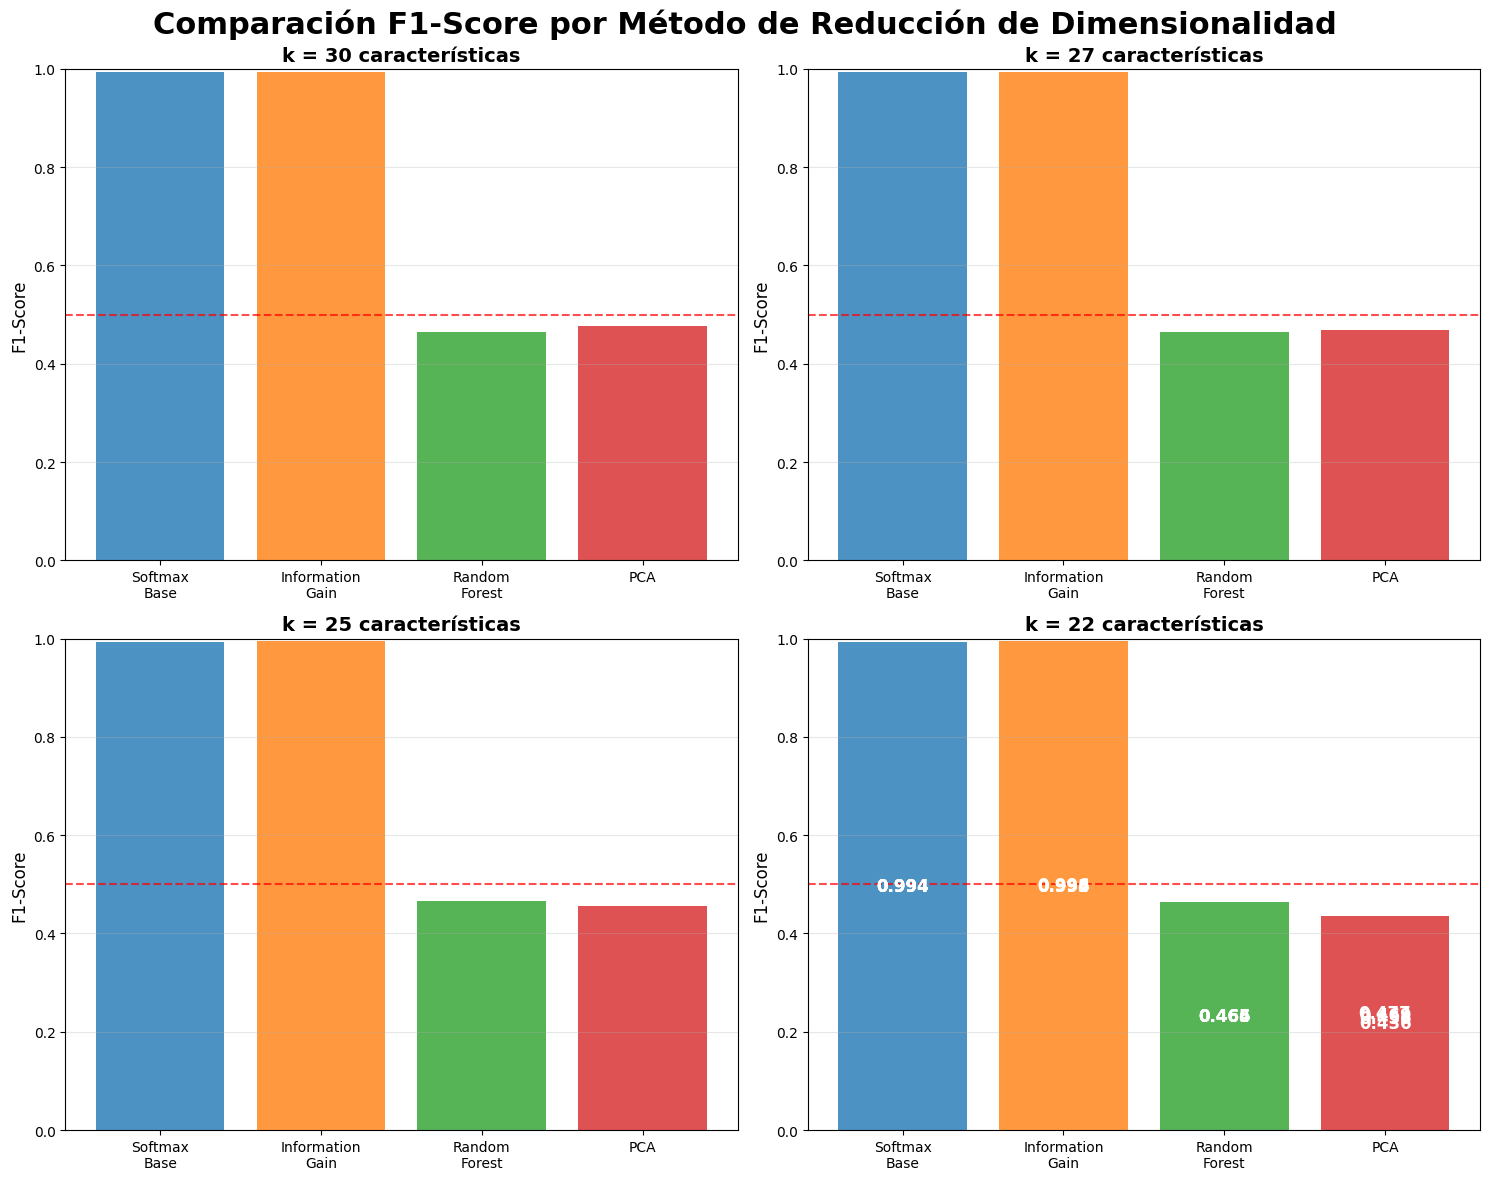

In [12]:
# Codigo para generar un comparativo entre distintos ks
def information_gain_selection(X_train, y_train, X_test, k):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    top_k_indices = np.argsort(mi_scores)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

def random_forest_feature_importance(X_train, y_train, X_test, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    top_k_indices = np.argsort(importances)[-k:]

    X_train_selected = X_train[:, top_k_indices]
    X_test_selected = X_test[:, top_k_indices]

    return X_train_selected, X_test_selected, top_k_indices

def pca_dimensionality_reduction(X_train, X_test, n_components):

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return X_train_pca, X_test_pca, cumulative_variance


k_values = [30, 27, 25, 22]

X_train_ig_30, X_test_ig_30, ig_indices_30 = information_gain_selection(X_train, y_train, X_test, k=30)
w_ig_30, loss_train_ig_30, loss_test_ig_30 = train(X_train_ig_30, y_train, epochs, alpha, X_test_ig_30, y_test)
y_pred_ig_30, acc_ig_30 = test(X_test_ig_30, y_test, w_ig_30)

X_train_rf_30, X_test_rf_30, rf_indices_30 = random_forest_feature_importance(X_train, y_train, X_test, k=30)
w_rf_30, loss_train_rf_30, loss_test_rf_30 = train(X_train_rf_30, y_train, epochs, alpha, X_test_rf_30, y_test)
y_pred_rf_30, acc_rf_30 = test(X_test_rf_30, y_test, w_rf_30)

X_train_pca_30, X_test_pca_30, variance_explained_30 = pca_dimensionality_reduction(X_train, X_test, n_components=30)
w_pca_30, loss_train_pca_30, loss_test_pca_30 = train(X_train_pca_30, y_train, epochs, alpha, X_test_pca_30, y_test)
y_pred_pca_30, acc_pca_30 = test(X_test_pca_30, y_test, w_pca_30)

X_train_ig_27, X_test_ig_27, ig_indices_27 = information_gain_selection(X_train, y_train, X_test, k=27)
w_ig_27, loss_train_ig_27, loss_test_ig_27 = train(X_train_ig_27, y_train, epochs, alpha, X_test_ig_27, y_test)
y_pred_ig_27, acc_ig_27 = test(X_test_ig_27, y_test, w_ig_27)

X_train_rf_27, X_test_rf_27, rf_indices_27 = random_forest_feature_importance(X_train, y_train, X_test, k=27)
w_rf_27, loss_train_rf_27, loss_test_rf_27 = train(X_train_rf_27, y_train, epochs, alpha, X_test_rf_27, y_test)
y_pred_rf_27, acc_rf_27 = test(X_test_rf_27, y_test, w_rf_27)

X_train_pca_27, X_test_pca_27, variance_explained_27 = pca_dimensionality_reduction(X_train, X_test, n_components=27)
w_pca_27, loss_train_pca_27, loss_test_pca_27 = train(X_train_pca_27, y_train, epochs, alpha, X_test_pca_27, y_test)
y_pred_pca_27, acc_pca_27 = test(X_test_pca_27, y_test, w_pca_27)

X_train_ig_25, X_test_ig_25, ig_indices_25 = information_gain_selection(X_train, y_train, X_test, k=25)
w_ig_25, loss_train_ig_25, loss_test_ig_25 = train(X_train_ig_25, y_train, epochs, alpha, X_test_ig_25, y_test)
y_pred_ig_25, acc_ig_25 = test(X_test_ig_25, y_test, w_ig_25)

X_train_rf_25, X_test_rf_25, rf_indices_25 = random_forest_feature_importance(X_train, y_train, X_test, k=25)
w_rf_25, loss_train_rf_25, loss_test_rf_25 = train(X_train_rf_25, y_train, epochs, alpha, X_test_rf_25, y_test)
y_pred_rf_25, acc_rf_25 = test(X_test_rf_25, y_test, w_rf_25)

X_train_pca_25, X_test_pca_25, variance_explained_25 = pca_dimensionality_reduction(X_train, X_test, n_components=25)
w_pca_25, loss_train_pca_25, loss_test_pca_25 = train(X_train_pca_25, y_train, epochs, alpha, X_test_pca_25, y_test)
y_pred_pca_25, acc_pca_25 = test(X_test_pca_25, y_test, w_pca_25)

X_train_ig_22, X_test_ig_22, ig_indices_22 = information_gain_selection(X_train, y_train, X_test, k=22)
w_ig_22, loss_train_ig_22, loss_test_ig_22 = train(X_train_ig_22, y_train, epochs, alpha, X_test_ig_22, y_test)
y_pred_ig_22, acc_ig_22 = test(X_test_ig_22, y_test, w_ig_22)

X_train_rf_22, X_test_rf_22, rf_indices_22 = random_forest_feature_importance(X_train, y_train, X_test, k=22)
w_rf_22, loss_train_rf_22, loss_test_rf_22 = train(X_train_rf_22, y_train, epochs, alpha, X_test_rf_22, y_test)
y_pred_rf_22, acc_rf_22 = test(X_test_rf_22, y_test, w_rf_22)

X_train_pca_22, X_test_pca_22, variance_explained_22 = pca_dimensionality_reduction(X_train, X_test, n_components=22)
w_pca_22, loss_train_pca_22, loss_test_pca_22 = train(X_train_pca_22, y_train, epochs, alpha, X_test_pca_22, y_test)
y_pred_pca_22, acc_pca_22 = test(X_test_pca_22, y_test, w_pca_22)

def calculate_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

f1_base = calculate_f1_score(y_test, y_pred)

f1_ig_30 = calculate_f1_score(y_test, y_pred_ig_30)
f1_rf_30 = calculate_f1_score(y_test, y_pred_rf_30)
f1_pca_30 = calculate_f1_score(y_test, y_pred_pca_30)

f1_ig_27 = calculate_f1_score(y_test, y_pred_ig_27)
f1_rf_27 = calculate_f1_score(y_test, y_pred_rf_27)
f1_pca_27 = calculate_f1_score(y_test, y_pred_pca_27)

f1_ig_25 = calculate_f1_score(y_test, y_pred_ig_25)
f1_rf_25 = calculate_f1_score(y_test, y_pred_rf_25)
f1_pca_25 = calculate_f1_score(y_test, y_pred_pca_25)

f1_ig_22 = calculate_f1_score(y_test, y_pred_ig_22)
f1_rf_22 = calculate_f1_score(y_test, y_pred_rf_22)
f1_pca_22 = calculate_f1_score(y_test, y_pred_pca_22)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación F1-Score por Método de Reducción de Dimensionalidad', fontsize=22, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, k in enumerate(k_values):
    ax = axes[i//2, i%2]

    if k == 30:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_30, f1_rf_30, f1_pca_30]
    elif k == 27:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_27, f1_rf_27, f1_pca_27]
    elif k == 25:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_25, f1_rf_25, f1_pca_25]
    elif k == 22:
        models = ['Softmax\nBase', 'Information\nGain', 'Random\nForest', 'PCA']
        f1_scores = [f1_base, f1_ig_22, f1_rf_22, f1_pca_22]

    bars = ax.bar(models, f1_scores, color=colors, alpha=0.8)
    ax.set_title(f'k = {k} características', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_ylim(0, 1.0)

    for i, (bar, score) in enumerate(zip(bars, f1_scores)):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() / 2,
          f'{score:.3f}', ha='center', va='center', fontweight='bold',
             color='white', fontsize=12)

    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()